In [1]:
from AG_simple import AlgoritmoGenetico
from sumolib import checkBinary
import xml.etree.ElementTree as ET
import traci
import sys

from statistics import mean, stdev
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simulate(program):
    traci.start([checkBinary(program), "-c", "sumo-multi/light.sumocfg", "--tripinfo-output", "sumo-multi/tripinfo.xml"])
    
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        
    traci.close()
    sys.stdout.flush()
    
    xmldoc = ET.parse('sumo-multi/tripinfo.xml')

    tripinfos = xmldoc.findall('tripinfo')

    waitingTime = 0
    travelTime = 0
    for tripinfo in tripinfos:
        waitingTime += float(tripinfo.get('waitingTime'))
        travelTime += float(tripinfo.get('duration'))
        
    return waitingTime, travelTime

In [3]:
def display(fenotipo):
    red = ET.parse('sumo-multi/light.net.xml')
    signal = red.find('tlLogic')
    fases = signal.findall('phase')
    
    for i in range(4):
        fases[i].set("duration", str(fenotipo[2*i]))
        fases[i].set("state", fenotipo[2*i+1])

    red.write("sumo-multi/light.net.xml")

    return simulate('sumo-gui')

# ALTO

Si solo quieres ver los resultados avanza hasta la sección de experimentos

In [7]:
data = [0] * 188
ga = AlgoritmoGenetico(data)
ga.generations =  20
ga.population_size = 50
ga.crossover_probability = 0.9
ga.mutation_probability = 0.1
fitnesses = []

In [8]:
def fenotipo(genotipo):
    
    fenotipo = []
    m = ['G', 'g', 'y', 'r']
    
    for j in range(4):
        fenotipo.append(int(''.join(map(str,genotipo[:7])),2)) 

        state = genotipo[7:47]
        s = ""
        for i in range(0, 20):
            s += m[int(str(state[2*i])+str(state[2*i+1]),2)]
        fenotipo.append(s)

        genotipo = genotipo[47:]
    
    return fenotipo

In [9]:
w1, w2 = 0.5, 0.5

def fitness(individual, data):
    
    individual = fenotipo(individual)

    red = ET.parse('sumo-multi/light.net.xml')
    signal = red.find('tlLogic') 
    
    i = 0
    for phase in signal.iter('phase'):
        duration = str(individual[2*i])
        if duration == "0":
             return 0
        state = individual[2*i+1]
        phase.set("duration", duration)
        phase.set("state", state)
        i += 1

    red.write("sumo-multi/light.net.xml")
    
    salida_simulacion = simulate('sumo')

    waitingTime, travelTime = salida_simulacion
    
    fitness_total = 1 / (w1 * waitingTime + w2 * travelTime)

    fitnesses.append((waitingTime, travelTime))
          
    print(waitingTime, individual)
    
    return fitness_total

ga.fitness_function = fitness

In [10]:
ga.run()

548.4000000000001 [121, 'ryGryrrGGgGgryggGyyG', 59, 'rgGGGgggGyryGggygrGy', 24, 'rrrryrGryrrrrgyGrgry', 23, 'GGggrrggggGGGGgrGyGy']
1030.4 [2, 'GyrggGrryyrrgggGyryy', 80, 'ygyyryryGGGGggGggggr', 90, 'rGGyrgrGgyryrGrGrgGg', 46, 'GgyyrGyyGygyryGGrgGy']
3256.3999999999996 [80, 'GGrrGyrrrGyyggyGgrrg', 15, 'gyyGGGrrrgygGgGggyrG', 1, 'gygryGGgyGrGrgyGGyyg', 38, 'GrgrygGGrryggyrygGrr']
1577.2 [40, 'GGgGrggGGrgGgyGGyggy', 114, 'ggGyyyyrgyyryGGggrrg', 77, 'GGyyryryggyGGGGrGyrG', 80, 'rgyrGgGygyGyygGygrGG']
2254.7 [68, 'yGGgrggGgrggrrrygyGy', 15, 'gyrrgygGrrGrrgrGrygr', 7, 'yryggyGGygygGgryygGy', 75, 'Grgyrygggyyygrrrggry']
2449.7999999999997 [17, 'yrGyrGyGyGgrgygggrrg', 118, 'rgGyGGrggyrgryGrgryy', 58, 'ryGyGyGyyyryGrrGyygy', 29, 'gygyGrgrGGgyryrGrgGG']
1340.8999999999999 [95, 'GrrgrgrrGGrGGyGGgGGr', 34, 'gygggyygyrryGrrGggGy', 119, 'gygryryGgyGgrgGGryrr', 39, 'GGgyyyGrGGyyyGrrrGgg']
1311.5 [89, 'rGggrgyrrrGGrrgygGgr', 103, 'GygGGyGryggGyGGgGyGG', 45, 'yGggrrryryrrgggyggGr', 104, 'rygrrGgyGgyGg

In [11]:
best = fenotipo(ga.best_individual()[1])

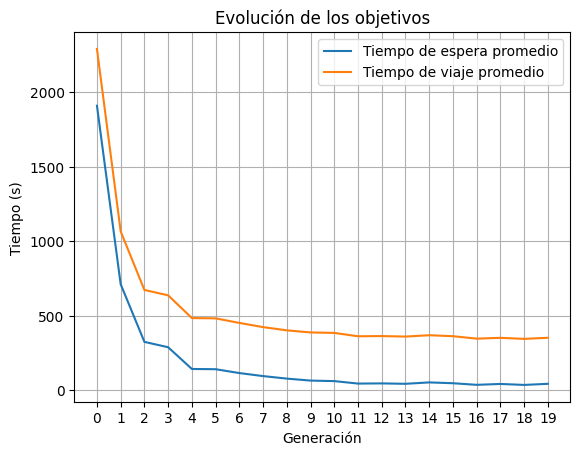

In [12]:
esperas = [f[0] for f in fitnesses]
viajes = [f[1] for f in fitnesses]

esperas_gen = []
viajes_gen = []

for i in range(ga.generations):
    datos_gen = fitnesses[i*ga.population_size:(i+1)*ga.population_size]
    esperas_gen.append(mean([x[0] for x in datos_gen]))
    viajes_gen.append(mean([x[1] for x in datos_gen]))

plt.plot(esperas_gen, label='Tiempo de espera promedio')
plt.plot(viajes_gen, label='Tiempo de viaje promedio')
plt.xticks(range(0, ga.generations, 1)) 
#plt.xticks([0, 1, 2, ,3, 4, 5. 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.xlabel("Generación")
plt.ylabel("Tiempo (s)")
plt.legend()
plt.title("Evolución de los objetivos")
plt.grid()
plt.show()

In [13]:
# mejor fitness
display(best)

(35.0, 342.2999999999999)

In [5]:
# visualización de una prueba default
prueba = [30, 'GGGGgrrrrrGGGGgrrrrr', 5, 'yyyyyrrrrryyyyyrrrrr', 30, 'rrrrrGGGGgrrrrrGGGGg', 5, 'rrrrryyyyyrrrrryyyyy']
display(prueba)

(322.79999999999995, 684.9999999999999)

# Experimentos

A continuación se tiene un registro de los experimentos realizados, para correrlos no es necesario volver a cargar todo el código, únicamente las primeras 3 casillas.

In [ ]:
# experimentos 1_n que alcanzaron 52.8 segundos de espera promedio

exp1_1 = [60, 'ggyGGygyggggGyggrGgy', 51, 'grrrgGrGryyygyggrgyG', 14, 'yrrrgGrrryrrgyGGGrgy', 4, 'ygyrgyryrggGyggGrgGy']

exp1_2 = [60, 'ggyGGygyggggGyggrGgy', 51, 'grrrgGrGryyygyggrgyG', 14, 'yrrrgGrrrrrgyGyyrGrr', 10, 'GGrryryGrgggyrGyyGgG']

exp1_4 = [60, 'ggyGGygyggggGyggrGgy', 51, 'grrrgGrGryyygyggrgyG', 14, 'yrrrgGrrryrrgyGGGyrr', 2, 'GGrryrygGrgyyggGrGgG']

exp1_3 = [124, 'ggyGGygyggggGyggrGgy', 51, 'grrrgGrGryyygyggrgyG', 14, 'yrrrgGrrryrrgyGGGrgy', 4, 'ygyrgyryrgggyrgGrGGy']

exp1_5 = [60, 'ggyGGygyggggGyggrGgy', 51, 'grrrgGrGryyygyggrgyG', 92, 'gryGygGyGgrrgyGGGrgy', 4, 'ygyryrygGrgyyggGrGgG']

display(exp1_1)

(52.8, 382.49999999999994)

In [14]:
# experimentos 2_n que alcanzaron 35.0 segundos de espera promedio

exp2_1 = [12, 'ryyrGGgGrrygyGGgGyGy', 5, 'ggGGGGrGyggGGgrGGGgG', 32, 'gGGGgGGyryGGgGGyGryG', 121, 'GrGyyggyGGrryrrGrgGr']

display(exp2_1)

(35.0, 343.5999999999999)